Starter EDA and ConvNet implementation using Keras. 

Inspiration for this notebook comes from this [Keras blog post](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) and the [VGG ConvNet paper](https://arxiv.org/pdf/1409.1556.pdf). 

In [5]:
import os, cv2, random
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop,SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras import backend as K 
K.set_image_dim_ordering('th') 

### Generating the Data
This part is to generate the train and test data.

In [32]:
TRAIN_DIR = './input/train/'
TEST_DIR = './input/test/'

ROWS = 96
COLS =96
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
train_images = train_dogs[2000:4000] + train_cats[2000:4000]
random.shuffle(train_images)
#test_images =  test_images[:25]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)
np.save('train_data.npy',train)
np.save('test_data.npy',test)
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 4000
Processed 250 of 4000
Processed 500 of 4000
Processed 750 of 4000
Processed 1000 of 4000
Processed 1250 of 4000
Processed 1500 of 4000
Processed 1750 of 4000
Processed 2000 of 4000
Processed 2250 of 4000
Processed 2500 of 4000
Processed 2750 of 4000
Processed 3000 of 4000
Processed 3250 of 4000
Processed 3500 of 4000
Processed 3750 of 4000
Processed 0 of 12500
Processed 250 of 12500
Processed 500 of 12500
Processed 750 of 12500
Processed 1000 of 12500
Processed 1250 of 12500
Processed 1500 of 12500
Processed 1750 of 12500
Processed 2000 of 12500
Processed 2250 of 12500
Processed 2500 of 12500
Processed 2750 of 12500
Processed 3000 of 12500
Processed 3250 of 12500
Processed 3500 of 12500
Processed 3750 of 12500
Processed 4000 of 12500
Processed 4250 of 12500
Processed 4500 of 12500
Processed 4750 of 12500
Processed 5000 of 12500
Processed 5250 of 12500
Processed 5500 of 12500
Processed 5750 of 12500
Processed 6000 of 12500
Processed 6250 of 12500
Processed 6500 of 12

### Generating the Labels

We're dealing with a binary classification problem here - (1) dog (0) cat. The lables can be created by looping over the file names in the train directory. It's nice to see the training data is perfectly balanced. 

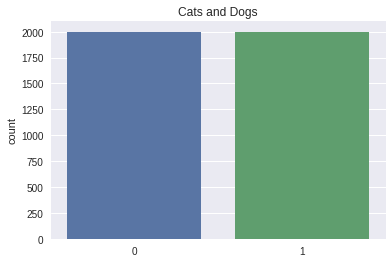

In [33]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)
np.save('train_labels_4000.npy',labels)
sns.countplot(labels)
sns.plt.title('Cats and Dogs')

## VGGNet-16

My model of the VGG-16, with a few notable changes.

- Fully connected (dense) layers scaled down. 
- Optimizer changed to `RMSprop`. 
- Output layer activation set to `sigmoid` for binary crossentropy. 




In [34]:
sgd = SGD(lr=0.1, decay=1e-6,momentum=0.5, nesterov=True)
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def VGG():
    model=Sequential()
    model.add(Conv2D(64, (3, 3), padding="same", activation="relu", input_shape=(3, 96, 96),name='bolck1_conv1'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))
    
    
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))
    
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))
    
    model.add(Flatten(name='flatten'))
    model.add(Dense(256, activation='relu', name='fc1'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu', name='fc2'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid', name='predictions'))
    

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = VGG()

### Train and Predict

I do not using Keras's early stopping callback to end training when the validation loss stops improving, otherwise the model will train for too few times. I will also be tracking the loss history on each epoch to visualize the overfitting trend. 


In [35]:
nb_epoch = 30
batch_size = 32

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')        
        
def run_catdog():
    
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.25, verbose=1, shuffle=True, callbacks=[history])
    

    predictions = model.predict(test, verbose=0)
    return predictions, history

predictions, history = run_catdog()

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 364s - loss: 0.7027 - acc: 0.5123 - val_loss: 0.6930 - val_acc: 0.4880

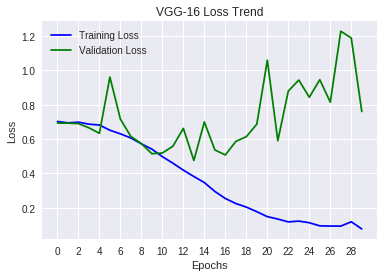

In [53]:
loss = history.losses

val_loss = history.val_losses
fig=plt.figure();
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()
fig.savefig('random.png')

In [35]:
prediction=predictions.clip(min=0.005, max=0.995)
TEST_DIR = './input/test/'
test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

for i, fname in enumerate(test_images):
    

    fname=fname.split('/')[3]
    fname=fname.split('.')[0]
    index = int(fname)
    df.set_value(index-1, 'label', prediction[i])

df.to_csv('pred.csv', index=None)
